In [1]:
# --- 1. Project Setup and Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib  # For saving the model

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Machine Learning Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# --- 2. Data Simulation ---
# We simulate a dataset as a placeholder for a real-world student survey or academic data.
np.random.seed(42)
size = 6000

df = pd.DataFrame({
    "Attendance": np.random.randint(50, 100, size),
    "Assignments": np.random.randint(50, 100, size),
    "GPA": np.round(np.random.uniform(5.0, 10.0, size), 2),
    "MissedDeadlines": np.random.randint(0, 6, size),
    "ExtraCurricular": np.random.randint(0, 10, size),
    "SleepHours": np.round(np.random.uniform(4, 9, size), 1),
    "ScreenTime": np.round(np.random.uniform(2, 10, size), 1),
    "SelfStudyHours": np.round(np.random.uniform(0, 6, size), 1),
    "MoodScore": np.random.randint(1, 6, size),
    "SleepQuality": np.random.randint(1, 6, size),
    "ProcrastinationIndex": np.round(np.random.uniform(0.0, 1.0, size), 2),
    "HealthIssues": np.random.randint(0, 2, size)
})

# --- 3. Feature Engineering: Create Target Variable ---
# Define a function to calculate a 'Burnout Score' based on predefined rules.
# This score will then be used to create our target labels ("Low", "Medium", "High").
def calculate_risk_score(row):
    score = 0
    if row['GPA'] < 6.0: score += 2
    elif row['GPA'] < 7.5: score += 1
    if row['Attendance'] < 65: score += 2
    elif row['Attendance'] < 80: score += 1
    if row['MissedDeadlines'] > 3: score += 2
    elif row['MissedDeadlines'] > 0: score += 1
    if row['SleepHours'] < 5: score += 2
    elif row['SleepHours'] <= 6.5: score += 1
    if row['SleepQuality'] <= 2: score += 2
    elif row['SleepQuality'] == 3: score += 1
    if row['MoodScore'] <= 2: score += 2
    elif row['MoodScore'] == 3: score += 1
    if row['ProcrastinationIndex'] > 0.7: score += 2
    elif row['ProcrastinationIndex'] >= 0.4: score += 1
    if row['HealthIssues'] == 1: score += 1
    return score

df['BurnoutScore'] = df.apply(calculate_risk_score, axis=1)

# Assign Burnout Risk labels based on the score.
def label_risk(score):
    if score <= 4: return "Low"
    elif score <= 9: return "Medium"
    else: return "High"

df['BurnoutRisk'] = df['BurnoutScore'].apply(label_risk)
df.drop(columns=['BurnoutScore'], inplace=True)

print("✅ Dataset successfully simulated and prepared.")
df.head()

✅ Dataset successfully simulated and prepared.


,Attendance,Assignments,GPA,MissedDeadlines,ExtraCurricular,SleepHours,ScreenTime,SelfStudyHours,MoodScore,SleepQuality,ProcrastinationIndex,HealthIssues,BurnoutRisk
0,88,80,6.32,4,0,4.2,3.4,5.7,2,1,0.93,1,High
1,78,52,8.56,3,4,8.5,2.6,5.3,3,1,0.87,1,Medium
2,64,57,5.50,2,0,8.1,7.6,5.7,3,2,0.85,1,High
3,92,73,5.17,4,2,7.6,8.9,2.3,4,5,0.88,1,Medium
4,57,64,7.80,3,9,7.0,8.5,5.3,2,3,0.45,1,Medium


--- Missing Values Check ---
Attendance              0
Assignments             0
GPA                     0
MissedDeadlines         0
ExtraCurricular         0
SleepHours              0
ScreenTime              0
SelfStudyHours          0
MoodScore               0
SleepQuality            0
ProcrastinationIndex    0
HealthIssues            0
BurnoutRisk             0
dtype: int64

No missing values found.


/tmp/ipython-input-622824692.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='BurnoutRisk', order=['Low', 'Medium', 'High'], palette='coolwarm')


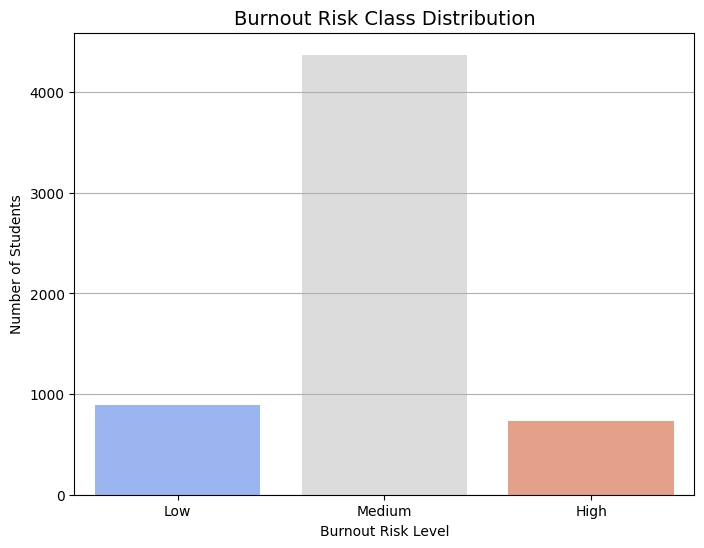

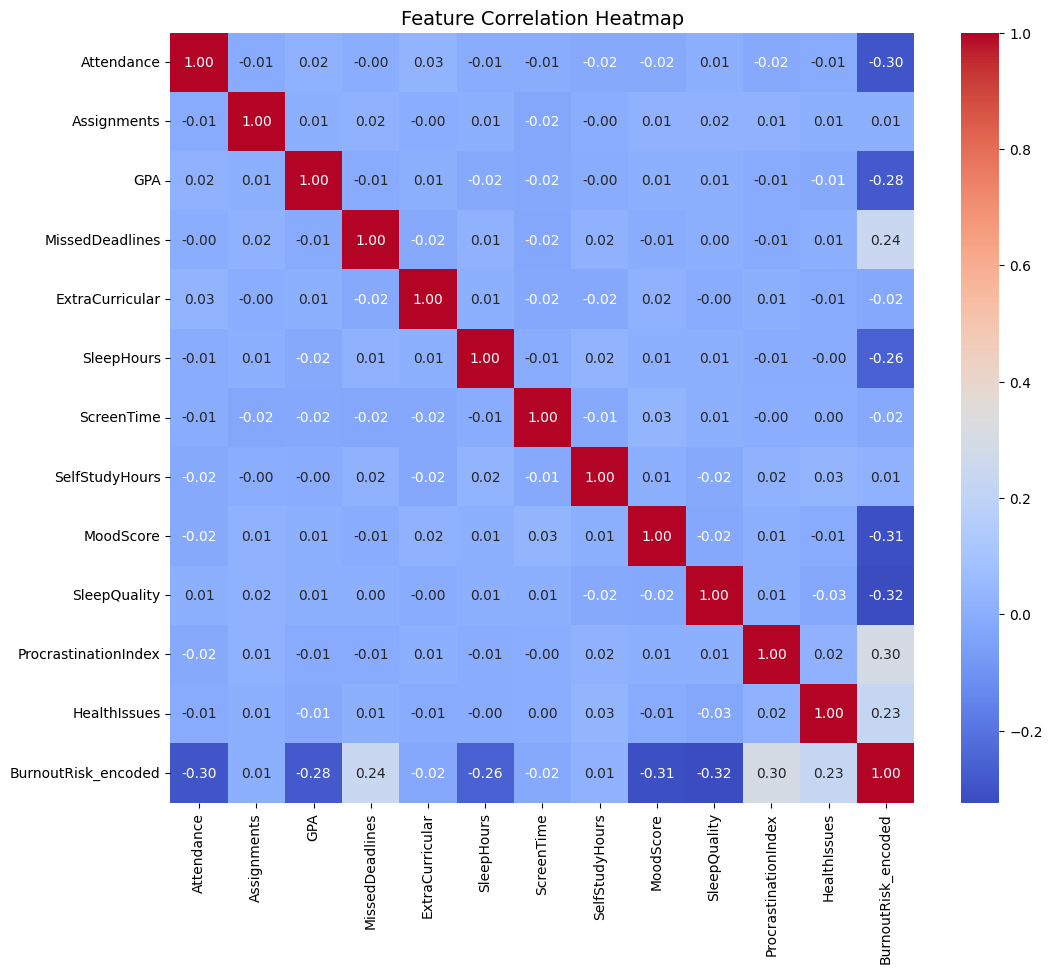

In [2]:
# --- 4. Exploratory Data Analysis (EDA) ---

# Check for missing values
print("--- Missing Values Check ---")
print(df.isnull().sum())
print("\nNo missing values found.")

# Analyze the distribution of the target variable
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='BurnoutRisk', order=['Low', 'Medium', 'High'], palette='coolwarm')
plt.title("Burnout Risk Class Distribution", fontsize=14)
plt.xlabel("Burnout Risk Level")
plt.ylabel("Number of Students")
plt.grid(axis='y')
plt.show()

# --- 5. Preprocessing for Modeling ---

# Encode the categorical target variable into numerical labels.
# It's important to establish a clear ordinal mapping.
risk_mapping = {'Low': 0, 'Medium': 1, 'High': 2}
df['BurnoutRisk_encoded'] = df['BurnoutRisk'].map(risk_mapping)

# Correlation heatmap to understand feature relationships
plt.figure(figsize=(12, 10))
# We include the encoded target variable to see how features correlate with it.
numeric_df = df.select_dtypes(include=np.number)
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Feature Correlation Heatmap", fontsize=14)
plt.show()

In [3]:
# --- 6. Feature Scaling and Data Splitting ---

# Define features (X) and the target (y)
X = df.drop(['BurnoutRisk', 'BurnoutRisk_encoded'], axis=1)
y = df['BurnoutRisk_encoded']

# Split the data BEFORE scaling to prevent data leakage from the test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,  # 20% for testing
    random_state=42,
    stratify=y     # Ensures the class distribution is the same in train and test sets
)

# Feature Scaling
# We fit the scaler ONLY on the training data and transform both train and test data.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data successfully split and scaled.")
print("Training set shape:", X_train_scaled.shape)
print("Test set shape:", X_test_scaled.shape)

Data successfully split and scaled.
Training set shape: (4800, 12)
Test set shape: (1200, 12)


In [4]:
# --- 7. Model Training and Evaluation ---

# Define a dictionary of models to evaluate
models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(random_state=42),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
}

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    print(f"--- Model: {name} ---")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    # We use the inverse of the mapping to show readable labels
    target_names = [k for k, v in sorted(risk_mapping.items(), key=lambda item: item[1])]
    print(classification_report(y_test, y_pred, target_names=target_names))

--- Model: Logistic Regression ---
Accuracy: 0.8883
              precision    recall  f1-score   support

         Low       0.84      0.73      0.78       179
      Medium       0.90      0.95      0.93       874
        High       0.84      0.73      0.78       147

    accuracy                           0.89      1200
   macro avg       0.86      0.80      0.83      1200
weighted avg       0.89      0.89      0.89      1200

--- Model: Random Forest ---
Accuracy: 0.8792
              precision    recall  f1-score   support

         Low       0.96      0.60      0.74       179
      Medium       0.86      1.00      0.92       874
        High       1.00      0.53      0.69       147

    accuracy                           0.88      1200
   macro avg       0.94      0.71      0.78      1200
weighted avg       0.89      0.88      0.87      1200

--- Model: SVM ---
Accuracy: 0.8808
              precision    recall  f1-score   support

         Low       0.83      0.71      0.77      

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [09:15:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


--- Model: XGBoost ---
Accuracy: 0.9425
              precision    recall  f1-score   support

         Low       1.00      0.85      0.92       179
      Medium       0.93      0.99      0.96       874
        High       0.95      0.76      0.84       147

    accuracy                           0.94      1200
   macro avg       0.96      0.87      0.91      1200
weighted avg       0.94      0.94      0.94      1200



/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [09:15:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


--- Final XGBoost Model Performance ---
Accuracy: 0.9633
              precision    recall  f1-score   support

         Low       1.00      0.90      0.95       179
      Medium       0.95      1.00      0.98       874
        High       0.99      0.83      0.90       147

    accuracy                           0.96      1200
   macro avg       0.98      0.91      0.94      1200
weighted avg       0.96      0.96      0.96      1200



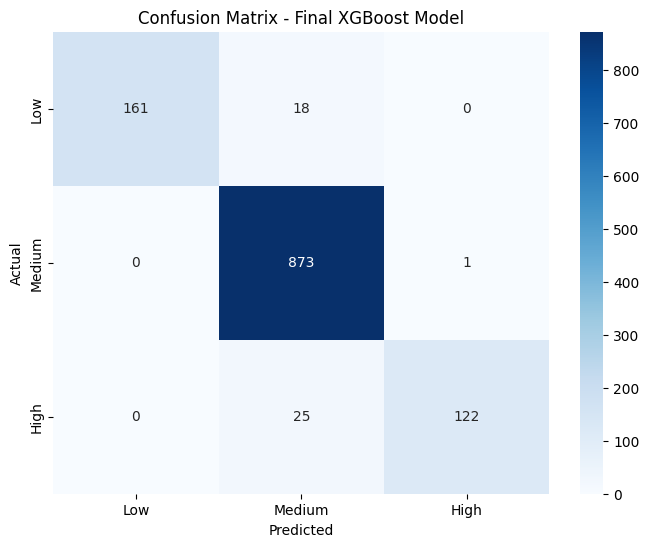

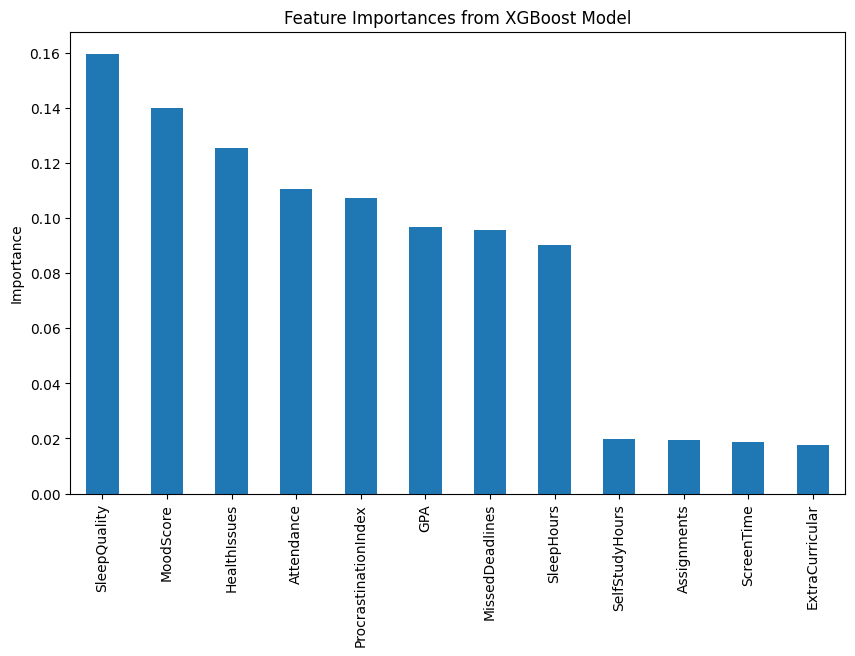

In [5]:
# --- 8. Final Model Selection and Feature Importance ---

# XGBoost performed the best. Let's create a final, tuned version.
final_xgb_model = XGBClassifier(
    random_state=42,
    n_estimators=200,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1,
    use_label_encoder=False,
    eval_metric='mlogloss'
)

final_xgb_model.fit(X_train_scaled, y_train)
y_pred_final = final_xgb_model.predict(X_test_scaled)

print("--- Final XGBoost Model Performance ---")
target_names = [k for k, v in sorted(risk_mapping.items(), key=lambda item: item[1])]
print(f"Accuracy: {accuracy_score(y_test, y_pred_final):.4f}")
print(classification_report(y_test, y_pred_final, target_names=target_names))

# Plot Confusion Matrix for the final model
cm = confusion_matrix(y_test, y_pred_final)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Final XGBoost Model")
plt.show()

# --- Feature Importance ---
feature_importances = pd.Series(final_xgb_model.feature_importances_, index=X.columns)
plt.figure(figsize=(10, 6))
feature_importances.sort_values(ascending=False).plot(kind='bar')
plt.title("Feature Importances from XGBoost Model")
plt.ylabel("Importance")
plt.show()

In [7]:
# --- 9. Save Model Artifacts for Deployment ---

# Use joblib to save the trained model, the scaler, and the mapping dictionary.
# These files can then be loaded in another script or application for making predictions.

joblib.dump(final_xgb_model, "burnout_xgb_model.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(risk_mapping, "risk_mapping.pkl")

print("✅ Model, scaler, and label mapping saved successfully.")

✅ Model, scaler, and label mapping saved successfully.


In [8]:
pip install shap

In [11]:
# --- 10. Data-Driven Feedback System with SHAP ---
import shap
import pandas as pd
import numpy as np
import joblib

# --- Load Model Artifacts ---
# Load the saved model, scaler, and label mapping from Step 9
loaded_model = joblib.load("burnout_xgb_model.pkl")
loaded_scaler = joblib.load("scaler.pkl")
loaded_mapping = joblib.load("risk_mapping.pkl")
inverse_mapping = {v: k for k, v in loaded_mapping.items()}

# --- Create a SHAP Explainer ---
# The TreeExplainer is optimized for tree-based models like XGBoost.
explainer = shap.TreeExplainer(loaded_model)

# --- Define a dictionary of actionable advice mapped to features ---
# This is our "knowledge base" for providing recommendations.
advice_knowledge_base = {
    "SleepHours": "Action: Aim for a consistent 7-8 hours of sleep per night to improve focus and reduce fatigue.",
    "ProcrastinationIndex": "Action: Break large tasks into smaller, manageable steps and use a planner to track deadlines.",
    "MissedDeadlines": "Action: Use a digital calendar with reminders to stay on top of all your assignment due dates.",
    "GPA": "Action: If your GPA is a concern, consider forming a study group or visiting your professor's office hours for help.",
    "Attendance": "Action: Make it a priority to attend classes. If you miss one, get notes from a classmate immediately.",
    "MoodScore": "Action: Pay attention to your mood. Activities like exercise, hobbies, or talking to a friend can help manage stress.",
    "SleepQuality": "Action: Improve sleep quality by creating a relaxing bedtime routine and avoiding screens before bed.",
    "HealthIssues": "Action: Don't ignore health issues. Visit the campus health center if you're not feeling well.",
    "Assignments": "Insight: Difficulty with assignments might be a sign of being overwhelmed. Prioritize and ask for help when needed.",
    "ExtraCurricular": "Insight: While important, ensure your extracurricular activities aren't overwhelming your academic commitments.",
    "ScreenTime": "Insight: High screen time, especially late at night, can affect sleep quality and mental fatigue.",
    "SelfStudyHours": "Insight: Low self-study hours can impact performance, while excessively high hours can also lead to burnout."
}

# --- Create the main prediction and explanation function ---
def analyze_student_burnout(student_data):
    """
    Predicts burnout risk for a new student and provides a full, data-driven analysis using SHAP.

    Args:
    student_data (dict): A dictionary with student feature values.

    Returns:
    None. Prints the prediction report.
    """
    # Create a DataFrame from the input dictionary
    student_df = pd.DataFrame([student_data])

    # Ensure the column order is the same as during training
    feature_order = loaded_scaler.feature_names_in_
    student_df = student_df[feature_order]

    # Scale the features using the loaded scaler
    student_scaled = loaded_scaler.transform(student_df)

    # --- Prediction ---
    prediction_encoded = loaded_model.predict(student_scaled)
    prediction_label = inverse_mapping[prediction_encoded[0]]
    prediction_proba = loaded_model.predict_proba(student_scaled)

    # --- SHAP Explanation ---
    # Calculate SHAP values for the specific student
    explanation = explainer(student_scaled)

    # We are interested in the SHAP values for the "High Risk" class (index 2 in our mapping)
    # The shape of explanation.values for one instance is (1, num_features, num_classes)
    # We select the values for the 'High' class (index 2)
    high_risk_shap_values = explanation.values[0, :, 2]

    # Create a DataFrame for easier analysis of SHAP values
    shap_df = pd.DataFrame({
        'feature': feature_order,
        'feature_value': student_df.iloc[0].values,
        'shap_value': high_risk_shap_values
    })

    # Get features that are pushing the risk HIGHER
    risk_factors = shap_df[shap_df['shap_value'] > 0].sort_values(by='shap_value', ascending=False)

    # Get features that are pushing the risk LOWER (protective factors)
    protective_factors = shap_df[shap_df['shap_value'] < 0].sort_values(by='shap_value', ascending=True)

    # --- Print the Final Report ---
    print("--- Student Burnout Risk Analysis ---")
    print(f"📈 Predicted Burnout Risk Level: {prediction_label.upper()}")
    print(f"   (Confidence: Low={prediction_proba[0][0]:.0%}, Medium={prediction_proba[0][1]:.0%}, High={prediction_proba[0][2]:.0%})")

    print("\n--- Key Factors Increasing Burnout Risk ---")
    if not risk_factors.empty:
        # Show top 3 factors
        for _, row in risk_factors.head(3).iterrows():
            print(f"• {row['feature']}: Your value of {row['feature_value']} is a significant contributor.")
            if row['feature'] in advice_knowledge_base:
                print(f"  > {advice_knowledge_base[row['feature']]}")
    else:
        print("• No significant factors were found to be increasing your risk.")

    print("\n--- Key Protective Factors (Reducing Risk) ---")
    if not protective_factors.empty:
        # Show top 2 protective factors
        for _, row in protective_factors.head(2).iterrows():
            print(f"• {row['feature']}: Your value of {row['feature_value']} is helping lower your risk. Keep it up!")
    else:
        print("• No significant protective factors identified.")

    print("------------------------------------")



In [12]:
# --- Example Usage ---
# Let's test with a student who is likely at high risk
high_risk_student = {
    'Attendance': 60,
    'Assignments': 55,
    'GPA': 5.8,
    'MissedDeadlines': 4,
    'ExtraCurricular': 1,
    'SleepHours': 5.2,
    'ScreenTime': 9.0,
    'SelfStudyHours': 1.5,
    'MoodScore': 2,
    'SleepQuality': 2,
    'ProcrastinationIndex': 0.9,
    'HealthIssues': 1
}

# Run the analysis
analyze_student_burnout(high_risk_student)

print("\n\n")

# Now, let's test with a student who should be low risk
low_risk_student = {
    'Attendance': 95,
    'Assignments': 92,
    'GPA': 9.1,
    'MissedDeadlines': 0,
    'ExtraCurricular': 5,
    'SleepHours': 7.8,
    'ScreenTime': 4.0,
    'SelfStudyHours': 4.0,
    'MoodScore': 5,
    'SleepQuality': 5,
    'ProcrastinationIndex': 0.1,
    'HealthIssues': 0
}

analyze_student_burnout(low_risk_student)

--- Student Burnout Risk Analysis ---
📈 Predicted Burnout Risk Level: HIGH
   (Confidence: Low=0%, Medium=0%, High=100%)

--- Key Factors Increasing Burnout Risk ---
• ProcrastinationIndex: Your value of 0.9 is a significant contributor.
  > Action: Break large tasks into smaller, manageable steps and use a planner to track deadlines.
• GPA: Your value of 5.8 is a significant contributor.
  > Action: If your GPA is a concern, consider forming a study group or visiting your professor's office hours for help.
• Attendance: Your value of 60.0 is a significant contributor.
  > Action: Make it a priority to attend classes. If you miss one, get notes from a classmate immediately.

--- Key Protective Factors (Reducing Risk) ---
• Assignments: Your value of 55.0 is helping lower your risk. Keep it up!
------------------------------------



--- Student Burnout Risk Analysis ---
📈 Predicted Burnout Risk Level: LOW
   (Confidence: Low=100%, Medium=0%, High=0%)

--- Key Factors Increasing Burnout

In [14]:
import joblib

joblib.dump(final_xgb_model, "burnout_xgb_model.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(risk_mapping, "risk_mapping.pkl")


['risk_mapping.pkl']

In [15]:
from google.colab import files
files.download("burnout_xgb_model.pkl")
files.download("scaler.pkl")
files.download("risk_mapping.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>